# 配置

In [1]:
settings = {
    "width": 256,
    "height": 256,
    'rotation_step': 60, # 旋转的粒度
    'scale': 0.05, # 每个像素的大小，单位：米
    'initial_grid': 1.0, # 枚举扫描位置时使用的初始间隔
    'ignore': 0.20,
    'threshold': 0.3,

    # 数据集位置
    "dataset": "../hm3d_train/",
    "dataset_config": "../hm3d_train/hm3d_annotated_train_basis.scene_dataset_config.json", # Configuration of the dataset
    "classes_json": "../topdown/train/classes.json",


    # 采样结果的储存位置
    "groundtruth_path": "../topdown/train/",

    "resume": 131,

    "sensor_height": 1.5,  # 传感器的高度，单位：米
    "enable_physics": False, 
}

# 运行全部

In [2]:
from utils import make_samples, display_sample, display_nav_mesh, tqdm
import os
import torch
import sys
from models.common import device
from models.perception.mapping.mapping import local_semantic_map


/home/wzj/anaconda3/envs/habitat/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Habitat

In [3]:
import habitat_sim

In [4]:
from models.perception.utils import (
    quaternion2radian, 
    depth_map_to_point_cloud, 
    rotate_point_cloud, 
    fall_on_map,
    ClassManager,
    display_semantic_map
)

def look_around(relative_position: tuple, sim: habitat_sim.Simulator, global_map: torch.Tensor, class_manager: ClassManager, tmp:torch.Tensor=None):
    instance_map = []
    depth_map = []
    degrees = []

    for t in range(int(360 / settings['rotation_step'])):
        obs = sim.step('turn_right')
        instance_map.append(torch.tensor(obs['semantic_sensor'] * 1.0).to(device))
        depth_map.append(torch.tensor(obs['depth_sensor'] * 1.0).to(device))
        degrees.append(quaternion2radian(sim.get_agent(0).get_state().rotation))


    depth_map = torch.stack(depth_map)
    instance_map = torch.stack(instance_map)
    semantic_map = class_manager.instance_to_global(instance_map)
    assert (semantic_map != class_manager.recover(class_manager.reduce(semantic_map))).sum() == 0
    semantic_map = class_manager.reduce(semantic_map)
    degrees = torch.stack(degrees).to(device)

    fall_on_map(
        rotate_point_cloud(
            depth_map_to_point_cloud(
                depth_map,
                torch.tensor(-1.0).acos() / 2
            ),
            degrees
        ),
        semantic_map,
        global_map,
        relative_position,
        settings['scale'],
        tmp=tmp
    )



In [5]:
from torch.nn.functional import max_pool2d, avg_pool2d

def explore(sim, class_manager: ClassManager, global_semantic_map:torch.Tensor=None, tmp:torch.Tensor=None):
    with torch.no_grad():
        height = sim.pathfinder.get_bounds()[0][1]
        bounds = sim.pathfinder.get_bounds()[0]
        bounds = torch.tensor([bounds[2],bounds[0]]).to(device).flatten()

        nav_mesh = torch.tensor(sim.pathfinder.get_topdown_view(settings['scale'], height)).to(device)
        for t in range(10):
            nav_mesh = nav_mesh | torch.tensor(sim.pathfinder.get_topdown_view(settings['scale'], height + t * 0.1)).to(device)
        for t in range(10):
            nav_mesh = nav_mesh | torch.tensor(sim.pathfinder.get_topdown_view(settings['scale'], height - t * 0.1)).to(device)

        if global_semantic_map is None:
            global_semantic_map = torch.zeros([class_manager.get_local_class_number()] + list(nav_mesh.shape)).to(device)
        if tmp is None:
            tmp = torch.zeros(global_semantic_map.shape).to(device)

        grid = settings['initial_grid']
        count = 0
        while True:
            grid_px = int(grid / settings['scale'])
            if grid_px <= 1 or grid_px <= settings['ignore'] / settings['scale']:
                break

            ys, xs = torch.arange(0, nav_mesh.shape[0]).to(device), torch.arange(0, nav_mesh.shape[1]).to(device)
            ys, xs = ys.unsqueeze(dim=1).expand(-1, nav_mesh.shape[1]), xs.unsqueeze(dim=0).expand(nav_mesh.shape[0], -1)
            coords, ys, xs = torch.stack([ys, xs], dim=0).type(torch.float) + 0.5, None, None
            # coords 目前是像素坐标
            coords = coords * nav_mesh.unsqueeze(dim=0)
            navigatable = (max_pool2d(nav_mesh.unsqueeze(dim=0).type(torch.float), kernel_size=grid_px) > 0).reshape(-1)
            coords = avg_pool2d(coords, kernel_size=grid_px).reshape(2, -1)[:, navigatable] / avg_pool2d(nav_mesh.unsqueeze(dim=0).type(torch.float), kernel_size=grid_px).reshape(-1)[navigatable]
            # coords 目前包含所有可导航的粗像素的可导航中心

            coarse_semantic_map = (avg_pool2d(global_semantic_map.max(dim=0)[0].unsqueeze(dim=0).clamp(max=1), kernel_size=grid_px) > settings['threshold']).squeeze(dim=0)
            coords = coords[:, ~coarse_semantic_map.reshape(-1)[navigatable]]
            # coords 目前包含所有可导航且不满足要求的粗像素的可导航中心


            coords = coords * settings['scale']
            coords = coords.transpose(0, 1)
            abs_coords = coords + bounds

            if len(coords) == 0 or count >= 10:
                print(f"grid={grid}m done")
                grid /= 2
                continue
            count += 1

            for i in tqdm(range(len(coords)), f'grid={grid:.3f}m'):
                pos = sim.pathfinder.get_random_navigable_point_near(
                    [abs_coords[i][1].item(), height, abs_coords[i][0].item()], 
                    radius=settings['scale'] * grid_px
                )
                if not sim.pathfinder.is_navigable(pos):
                    continue

                state = habitat_sim.AgentState(
                    position=pos,
                    rotation=sim.get_agent(0).get_state().rotation
                )
                sim.get_agent(0).set_state(state=state, reset_sensors=False)
                sim.step('turn_left')

                pos = sim.get_agent(0).get_state().position
                pos = torch.tensor([pos[2], pos[0]]).to(device)
                relative_pos = pos - bounds
                look_around(
                    relative_pos,
                    sim,
                    global_semantic_map,
                    class_manager,
                    tmp=tmp
                )
        return global_semantic_map, nav_mesh


In [6]:
def save_scene(scene_name: str, global_semantic_map: torch.Tensor, class_manager: ClassManager):
    path = os.path.join(settings['groundtruth_path'], scene_name)
    torch.save(global_semantic_map, path + '.gsm')
    class_manager.save(path + '.cm')

def explore_scene(sim:habitat_sim.Simulator, scene_dir:str, scene_name:str=None):
    class_manager = ClassManager.from_sim(sim, settings['classes_json']) 
    global_semantic_map, nav_mesh = explore(sim, class_manager)

    display_semantic_map(global_semantic_map)
    display_nav_mesh(nav_mesh.cpu().numpy())
    save_scene(scene_name, global_semantic_map, class_manager)

    cm_path = os.path.join(settings['groundtruth_path'], scene_name + '.cm')
    loaded_cm = ClassManager.load(cm_path, settings['classes_json'])

    assert (class_manager.local_to_global != loaded_cm.local_to_global).sum() == 0
    assert (class_manager.global_to_local != loaded_cm.global_to_local).sum() == 0


  0%|          | 0/145 [00:00<?, ?it/s]

00567-KjZrPggnHm8
done
00723-hWDDQnSDMXb
done
00006-HkseAnWCgqk
done
00263-GGBvSFddQgs
done
00009-vLpv2VX547B
done
00592-CthA7sQNTPK
done
00022-gmuS7Wgsbrx
done
00643-ggNAcMh8JPT
done
00238-j6fHrce9pHR
done
00466-xAHnY3QzFUN
done
00255-NGyoyh91xXJ
done
00688-SgkmkWjjmDJ
done
00330-WhNyDTnd9g5
done
00256-92vYG1q49FY
done
00323-yHLr6bvWsVm
done
00746-RTV2n6fXB2w
done
00251-wsAYBFtQaL7
done
00541-FnDDfrBZPhh
done
00241-h6nwVLpAKQz
done
00397-ZNanfzgCdm3
done
00217-qz3829g1Lzf
done
00547-9h5JJxM6E5S
done
00591-JptJPosx1Z6
done
00475-g7hUFVNac26
done
00327-xgLmjqzoAzF
done
00619-R9fYpvCUkV7
done
00707-XVSZJAtHKdi
done
00539-zUG6FL9TYeR
done
00017-oEPjPNSPmzL
done
00712-HZ2iMMBsBQ9
done
00638-iePHCSf119p
done
00272-kA2nG18hCAr
done
00732-Z2DQddYp1fn
done
00326-u9rPN5cHWBg
done
00534-DBBESbk4Y3k
done
00020-XYyR54sxe6b
done
00210-j2EJhFEQGCL
done
00043-Jfyvj3xn2aJ
done
00108-oStKKWkQ1id
done
00410-v7DzfFFEpsD
done
00143-5Kw4nGdqYtS
done
00537-oahi4u45xMf
done
00035-3XYAD64HpDr
done
00606-W16Bm

grid=1.000m: 100%|██████████| 71/71 [00:02<00:00, 27.09it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


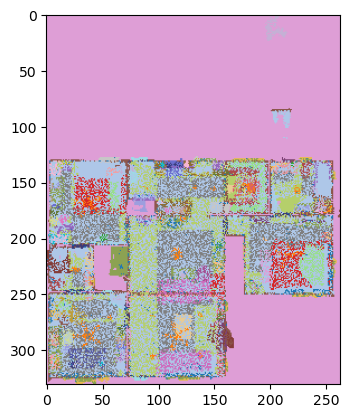

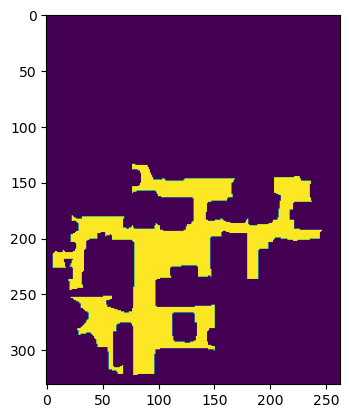

 91%|█████████ | 132/145 [00:10<00:01, 12.21it/s]

deleting 00680-YmWinf3mhb5/YmWinf3mhb5.basis.navmesh
deleting 00680-YmWinf3mhb5/YmWinf3mhb5.basis.glb
00299-bdp1XNEdvmW
515 objects, 1408 classes, 101 local classes


grid=1.000m: 100%|██████████| 109/109 [00:03<00:00, 27.59it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


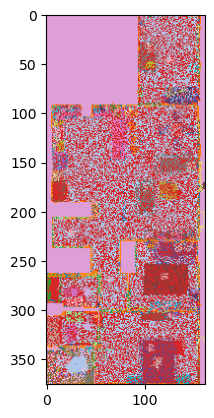

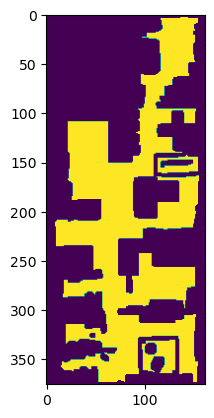

deleting 00299-bdp1XNEdvmW/bdp1XNEdvmW.basis.navmesh
deleting 00299-bdp1XNEdvmW/bdp1XNEdvmW.basis.glb
00668-6YtDG3FhNvx
396 objects, 1408 classes, 62 local classes


grid=1.000m: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


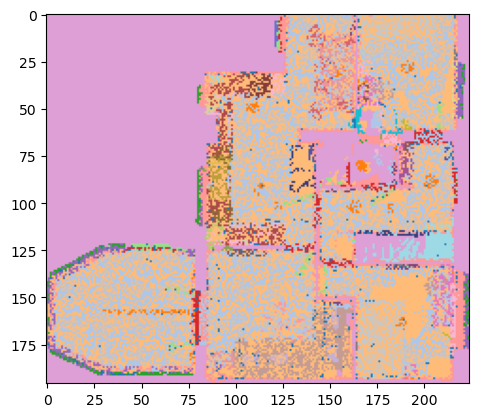

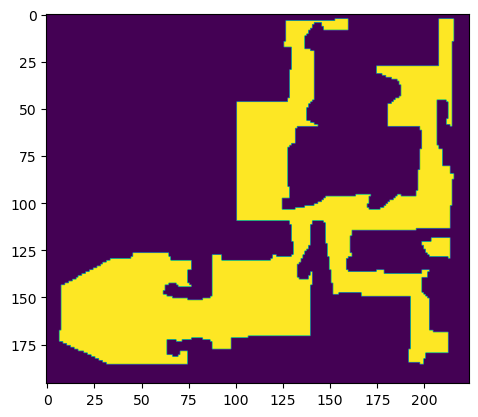

 92%|█████████▏| 134/145 [00:28<00:02,  3.69it/s]

deleting 00668-6YtDG3FhNvx/6YtDG3FhNvx.basis.navmesh
deleting 00668-6YtDG3FhNvx/6YtDG3FhNvx.basis.glb
00388-pcpn6mFqFCg
866 objects, 1408 classes, 139 local classes


[17:06:33:317579]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
grid=1.000m: 100%|██████████| 63/63 [00:02<00:00, 23.80it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


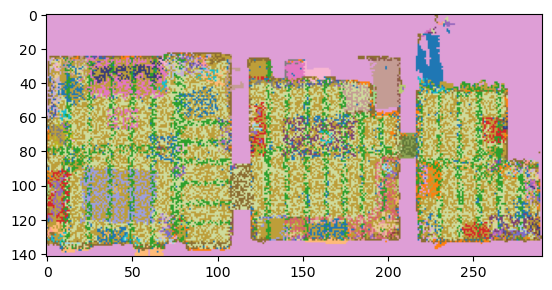

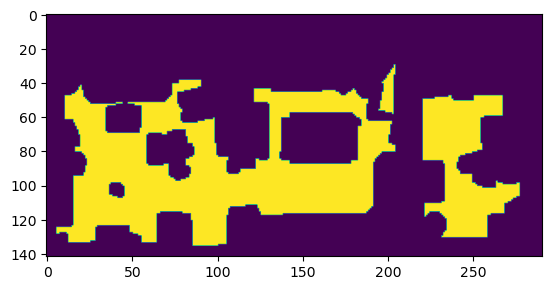

 93%|█████████▎| 135/145 [00:39<00:04,  2.35it/s]

deleting 00388-pcpn6mFqFCg/pcpn6mFqFCg.basis.navmesh
deleting 00388-pcpn6mFqFCg/pcpn6mFqFCg.basis.glb
00258-2Pc8W48bu21
1012 objects, 1408 classes, 102 local classes


[17:06:53:393252]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
grid=1.000m: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


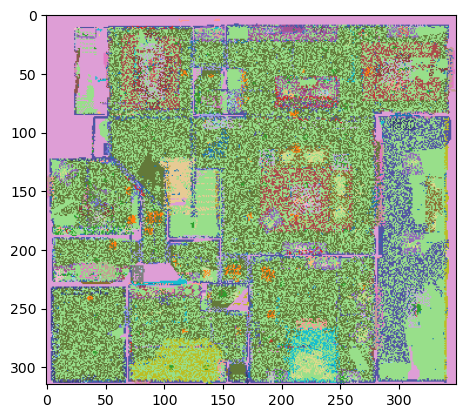

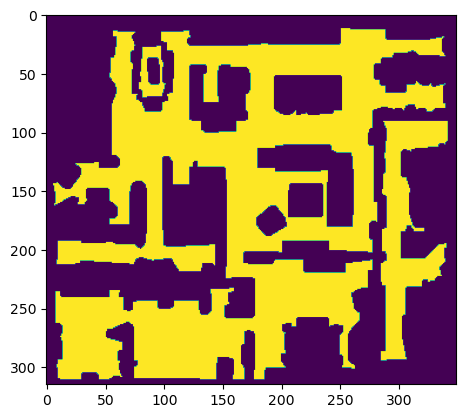

 94%|█████████▍| 136/145 [01:01<00:07,  1.13it/s]

deleting 00258-2Pc8W48bu21/2Pc8W48bu21.basis.navmesh
deleting 00258-2Pc8W48bu21/2Pc8W48bu21.basis.glb
00444-sX9xad6ULKc
490 objects, 1408 classes, 80 local classes


grid=1.000m: 100%|██████████| 4/4 [00:00<00:00, 26.91it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


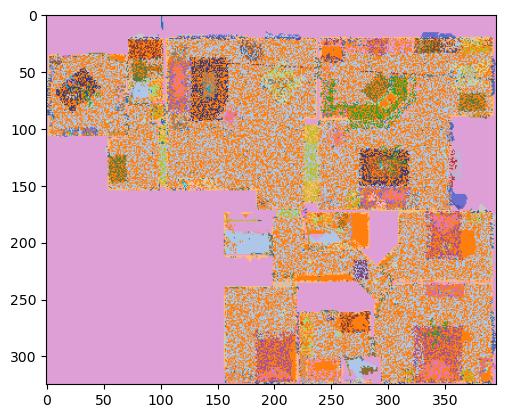

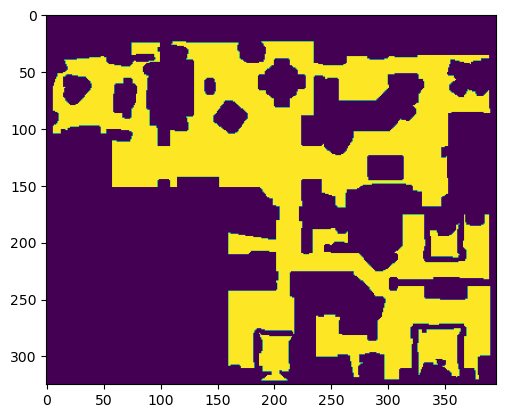

 94%|█████████▍| 137/145 [01:20<00:11,  1.39s/it]

deleting 00444-sX9xad6ULKc/sX9xad6ULKc.basis.navmesh
deleting 00444-sX9xad6ULKc/sX9xad6ULKc.basis.glb
00173-qZ4B7U6XE5Y
764 objects, 1408 classes, 124 local classes


[17:07:25:628952]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
grid=1.000m: 100%|██████████| 1/1 [00:00<00:00, 26.94it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


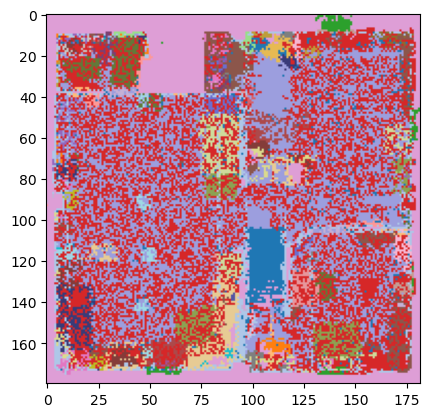

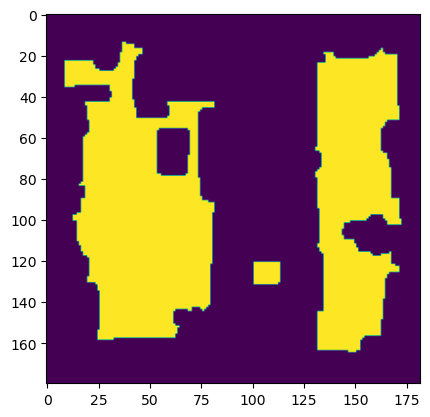

 95%|█████████▌| 138/145 [01:30<00:12,  1.73s/it]

deleting 00173-qZ4B7U6XE5Y/qZ4B7U6XE5Y.basis.navmesh
deleting 00173-qZ4B7U6XE5Y/qZ4B7U6XE5Y.basis.glb
00733-GtM3JtRvvvR
420 objects, 1408 classes, 66 local classes


grid=1.000m: 100%|██████████| 4/4 [00:00<00:00, 29.59it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


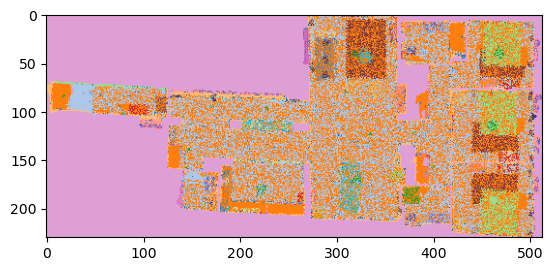

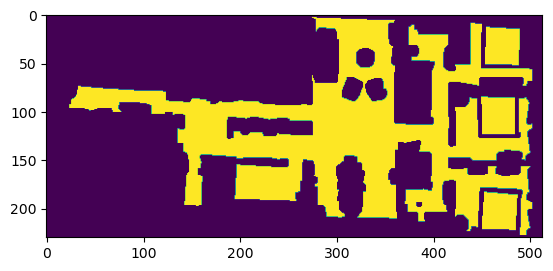

 96%|█████████▌| 139/145 [01:45<00:14,  2.45s/it]

deleting 00733-GtM3JtRvvvR/GtM3JtRvvvR.basis.navmesh
deleting 00733-GtM3JtRvvvR/GtM3JtRvvvR.basis.glb
00096-6HRFAUDqpTb
611 objects, 1408 classes, 120 local classes


[17:07:52:705407]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
grid=1.000m: 100%|██████████| 44/44 [00:02<00:00, 21.98it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


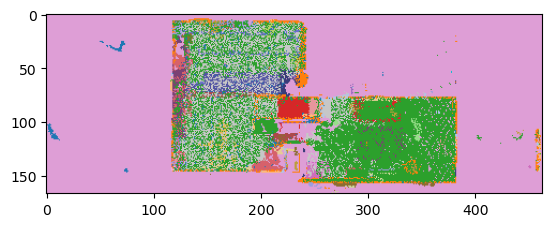

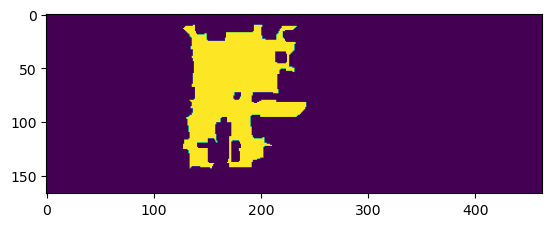

 97%|█████████▋| 140/145 [01:57<00:15,  3.11s/it]

deleting 00096-6HRFAUDqpTb/6HRFAUDqpTb.basis.navmesh
deleting 00096-6HRFAUDqpTb/6HRFAUDqpTb.basis.glb
00434-L5QEsaVqwrY
975 objects, 1408 classes, 134 local classes


[17:08:17:202097]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
[17:08:17:202225]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
[17:08:17:329867]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
[17:08:17:329962]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
[17:08:17:330089]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
[17:08:17:330472]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
[17:08:17:330557]:[Nav] PathFinder.cpp(1014)::getRand

grid=1.0m done
grid=0.5m done
grid=0.25m done


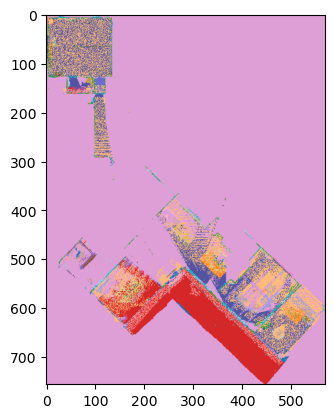

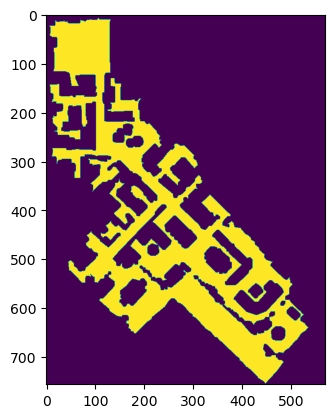

 97%|█████████▋| 141/145 [02:23<00:21,  5.25s/it]

deleting 00434-L5QEsaVqwrY/L5QEsaVqwrY.basis.navmesh
deleting 00434-L5QEsaVqwrY/L5QEsaVqwrY.basis.glb
00696-DsEJeNPcZtE
592 objects, 1408 classes, 80 local classes


grid=1.000m: 100%|██████████| 5/5 [00:00<00:00, 27.29it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


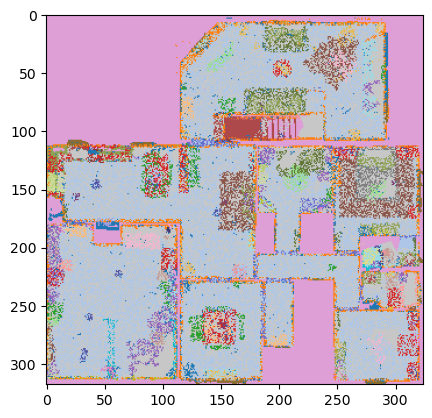

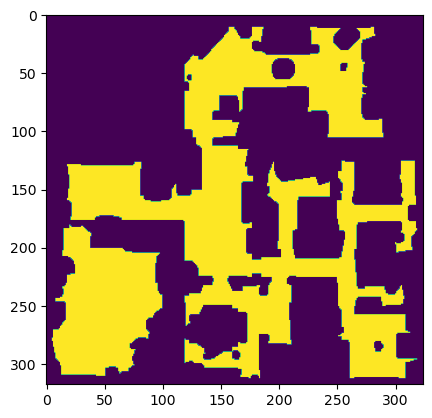

 98%|█████████▊| 142/145 [02:41<00:20,  6.75s/it]

deleting 00696-DsEJeNPcZtE/DsEJeNPcZtE.basis.navmesh
deleting 00696-DsEJeNPcZtE/DsEJeNPcZtE.basis.glb
00487-erXNfWVjqZ8
805 objects, 1408 classes, 168 local classes


grid=1.000m: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


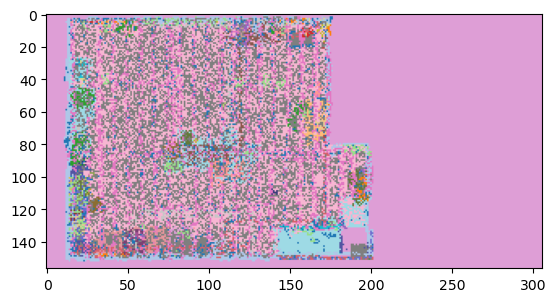

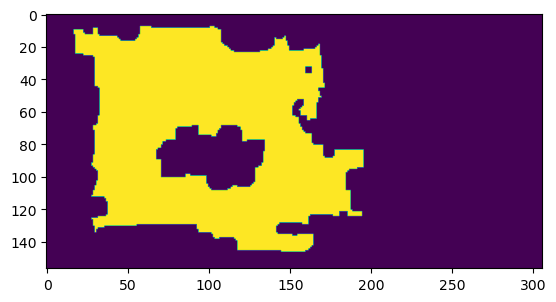

 99%|█████████▊| 143/145 [02:53<00:15,  7.53s/it]

deleting 00487-erXNfWVjqZ8/erXNfWVjqZ8.basis.navmesh
deleting 00487-erXNfWVjqZ8/erXNfWVjqZ8.basis.glb
00150-LcAd9dhvVwh
847 objects, 1408 classes, 101 local classes


[17:09:06:438668]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
grid=1.000m: 100%|██████████| 4/4 [00:00<00:00, 27.56it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


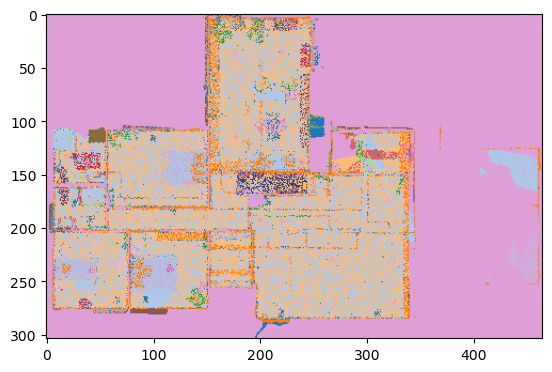

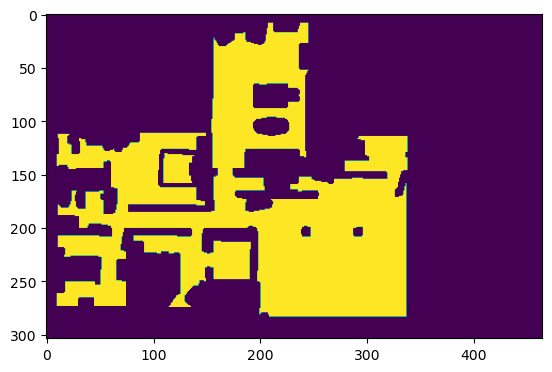

 99%|█████████▉| 144/145 [03:16<00:10, 10.06s/it]

deleting 00150-LcAd9dhvVwh/LcAd9dhvVwh.basis.navmesh
deleting 00150-LcAd9dhvVwh/LcAd9dhvVwh.basis.glb
00324-DoSbsoo4EAg
270 objects, 1408 classes, 65 local classes


[17:09:18:564421]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
[17:09:18:565660]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
[17:09:18:701157]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
[17:09:21:295880]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
grid=1.000m: 100%|██████████| 2/2 [00:00<00:00, 30.62it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


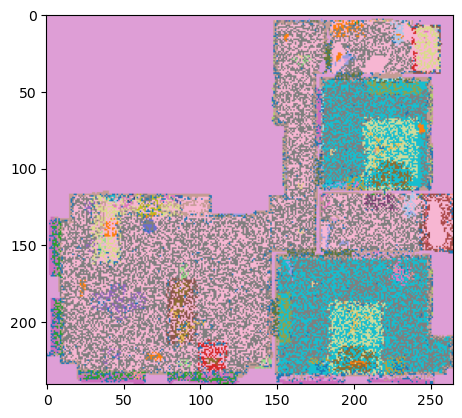

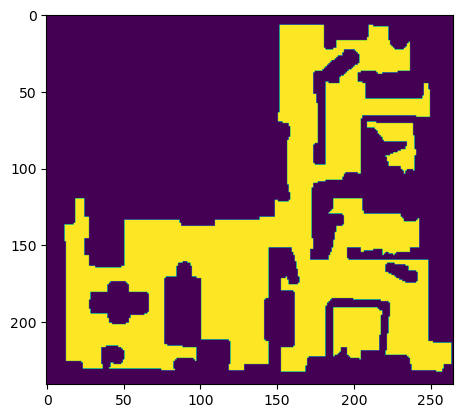

100%|██████████| 145/145 [03:25<00:00,  1.42s/it]

deleting 00324-DoSbsoo4EAg/DoSbsoo4EAg.basis.navmesh
deleting 00324-DoSbsoo4EAg/DoSbsoo4EAg.basis.glb


In [7]:
make_samples(settings, explore_scene)